In [2]:
from itertools import product
import numpy as np
import scipy
import scipy.special
import scipy.stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

 First we are computing $$\begin{align}
        INAL:=\mathbb{E}_{w} \left[\mathbb{E}_x \left[ \nabla_{w} L(f,w,x)\right]^{2}\right]
\end{align}$$
 where $L(f,w,x)$ is the hinge loss define as $L(f,w,x)=\max\left[0,1-f(x)ReLU(w\cdot x+b)\right]$ and $f$ is the full parity function on $\{+1,-1\}^d$.

We are doing the computation for one coordinate, say $x_d$. So we are computing ($H$ is the step function) $$\begin{align}INAL(d)&:=\mathbb{E}_{w} \left[\mathbb{E}_x \left[ \frac{\partial L(f,w,x) }{\partial w_d}\right]^{2}\right]=\mathbb{E}_{w} \left[\mathbb{E}_{x,x'} \left[ \frac{\partial L(f,w,x) }{\partial w_d}\times \frac{\partial L(f,w,x') }{\partial w_d}\right]\right]\\&=\mathbb{E}_{x,x'}\left[\mathbb{E}_w [x_df(x)H(w\cdot x+b)H(1-f(x)ReLU(w\cdot x+b))].[x'_df(x')H(w\cdot x'+b)H(1-f(x')ReLU(w\cdot x'+b))]\right] \end{align}$$

Given $x,x'$ in $\{\pm 1\}^d$, let $k:=|\{1\le i\le d-1; x_i=-1\}|$ and  $dist:=|\{1\le i\le d-1; x_i\ne x'_i\}|$. Let's set $b=0$, we have 

$$\begin{align}
   INAL(d)&=\mathbb{E}_{x,x'}\left[(-1)^{dist}\Pr_w\left[w\cdot x\ge 0;w\cdot x'\ge0; 1-f(x)ReLU(w\cdot x)\ge0; 1-f(x')ReLU(w\cdot x')\ge0\right]\right]
\end{align}$$

 The following is when $w\sim\mathcal{N}(0,\frac{1}{d} Id)$ (and $f$ is still the full parity)

In [2]:
# Pr[ a_1 <= G_1 <= b_1, a_2 <= G_2 <= b_2 ] for (G_1,G_2)~N([0,0], [[1, rho], [rho, 1]])
def gaussian_prob(a1, b1, a2, b2, rho):
    GG = scipy.stats.multivariate_normal(mean=[0,0], cov=[[1,rho],[rho,1]], allow_singular=True)    
    return GG.cdf([b1, b2])-GG.cdf([a1, b2])-GG.cdf([b1, a2])+GG.cdf([a1, a2])

In [3]:
# Pr[ 0<= G_1 <= b_1, 0 <= G_2 <= b_2 ] for (G_1,G_2)~N([0,0], [[1, rho], [rho, 1]])
def gaussian_wrapper(fone, ftwo, rho):
    b1 = 1 if fone > 0 else np.inf
    b2 = 1 if ftwo > 0 else np.inf
    return gaussian_prob(0, b1, 0, b2, rho)

In [4]:
def hinge_parity_inal(d):
    res = 0
    # k = {1<= i <= d-1: x_i = -1}
    # dist = Hamming distance(x_1^(d-1), xprime_1^(d-1))
    for k in range(0, d):
        for dist in range(0, d):
            term = scipy.special.binom(d-1, k)*scipy.special.binom(d-1, dist)
            term *= (-1)**(2*k+dist) # prod_{i=1}^{d-1} x_i x'_i
            #if d==3: print(k, dist, term)
            for xd, xd_prime in [[1, 1], [-1, 1], [1, -1], [-1, -1]]:
                rho = (d-1-2*dist+xd*xd_prime)/d
                parity = (-1)**k * xd
                parity_prime = (-1)**(k+dist) * xd_prime
                prob = gaussian_wrapper(parity, parity_prime, rho)
                res += term * prob
    return res / 4.0**d

Here $w\sim\mathcal{N}(0,\frac{1}{d} Id)$ and $r$ is the random function $r(x)=Rad(1/2)$

In [5]:
#This compute the INAL for the random function r(x)=Rad(1/2) for all x in {+1,-1}^n
def hinge_random_inal(d):
    res = 0
    for dist in range(0, d):
        pre_term = scipy.special.binom(d-1, dist)
        for fx, fx_prime in [[1, 1], [-1, 1], [1, -1], [-1, -1]]:
            for xd, xd_prime in [[1, 1], [-1, 1], [1, -1], [-1, -1]]:
                term = pre_term * fx * fx_prime * xd * xd_prime
                rho = (d-1-2*dist+xd*xd_prime)/d
                prob = gaussian_wrapper(fx, fx_prime, rho)
                res += term * prob
    return res / 2.0**(d+3)

Next we compute difference, still with $w\sim\mathcal{N}(0,\frac{1}{d} Id)$ $$\mathbb{E}_{w} \left[\mathbb{E}_x \left[ \frac{\partial L(f,w,x) }{\partial w_d}-\frac{\partial L(r,w,x) }{\partial w_d}\right]^{2}\right]$$

In [6]:
# This compute the INAL of the difference between the two functions above
def hinge_difference_inal(d):
    res = 0
    for k in range(0, d):
        for dist in range(0, d):
            term = scipy.special.binom(d-1, k)*scipy.special.binom(d-1, dist)
#             print(term)
            for fx, fx_prime in [[1, 1], [-1, 1], [1, -1], [-1, -1]]:
                for xd, xd_prime in [[1, 1], [-1, 1], [1, -1], [-1, -1]]:
                    rho = (d-1-2*dist+xd*xd_prime)/d
                    parity = (-1)**k * xd
                    parity_prime = (-1)**(k+dist) * xd_prime

                    res += term * xd*xd_prime * parity*parity_prime * gaussian_wrapper(parity, parity_prime, rho)
                    res -= term * xd*xd_prime * parity*fx_prime * gaussian_wrapper(parity, fx_prime, rho)
                    res -= term * xd*xd_prime * fx*parity_prime * gaussian_wrapper(fx, parity_prime, rho)
                    res += term * xd*xd_prime * fx*fx_prime * gaussian_wrapper(fx, fx_prime, rho)
    return res / 4.0**(d+1)  

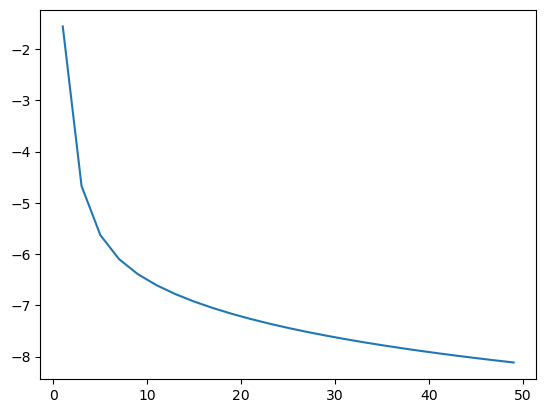

In [7]:
# plot of the log(INAL) of the parity
D = np.arange(1, 50,2)
parity_INAL = []
for d in D:
    res = hinge_parity_inal(d)
#     print(d, res)
    parity_INAL.append(res)
plt.plot(D,np.log(parity_INAL))

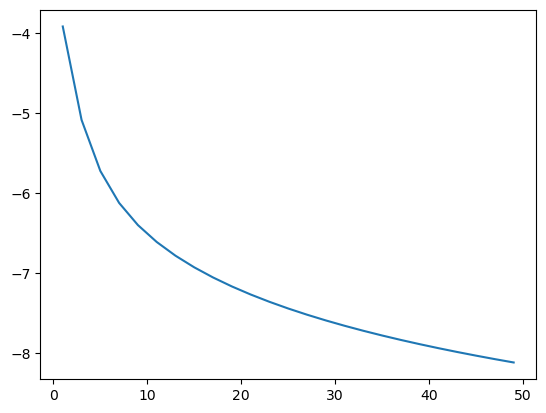

In [8]:
# plot of the log(INAL) of the random function

D = np.arange(1, 50,2)
random_INAL = []
for d in D:
    res = hinge_random_inal(d)
#     print(d, res)
    random_INAL.append(res)
plt.plot(D,np.log(random_INAL))

CPU times: user 9min 8s, sys: 53.1 s, total: 10min 1s
Wall time: 8min 52s


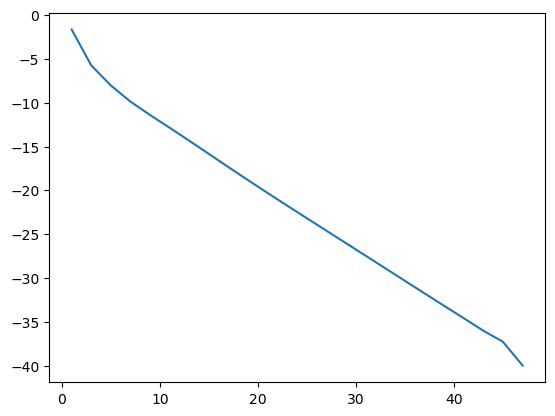

In [9]:
%%time
# plot of the log(INAL) of the difference

D = np.arange(1, 50,2)
diff_INAL = []
for d in D:
    res = hinge_difference_inal(d)
#     print(d, res)
    diff_INAL.append(res)
plt.plot(D,np.log(diff_INAL))   

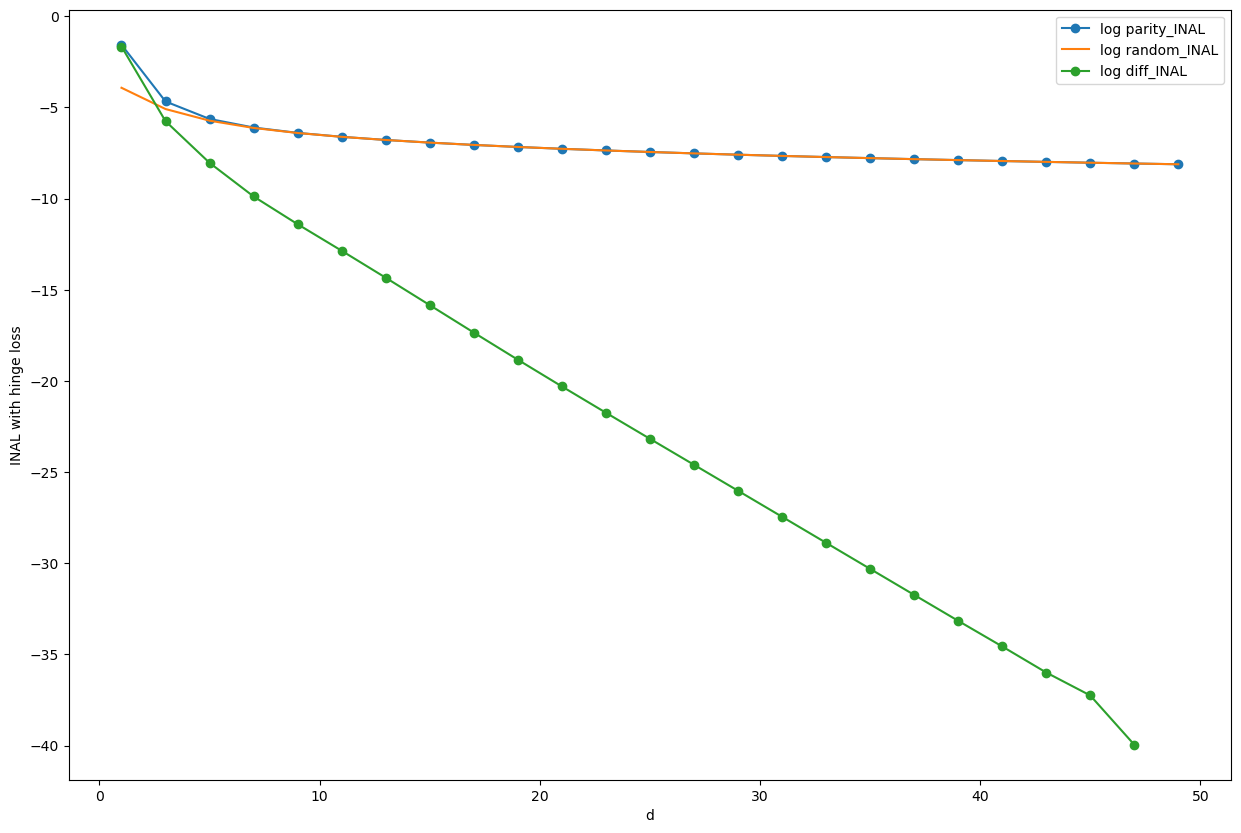

In [10]:
# All of them toghether

plt.figure(figsize=(15,10))
plt.plot(D, np.log(parity_INAL),"o-", label='log parity_INAL')
plt.plot(D, np.log(random_INAL), label='log random_INAL')
plt.plot(D, np.log(diff_INAL),"o-",label='log diff_INAL')
# plt.plot(D, -np.log(2)*D, label='log 2^{-D}')
# plt.plot(D, -np.log(D**2), label='log 1/D^2')
plt.xlabel("d")
plt.ylabel("INAL with hinge loss")
plt.legend();

In [11]:
def ReLU(x):
    return max([0,x])
ReLU=np.vectorize(ReLU)

def threshold(x):
    return x>=0

Here we compute difference, but with $w\sim Rad(1/2)$ $$\mathbb{E}_{w} \left[\mathbb{E}_x \left[ \frac{\partial L(f,w,x) }{\partial w_d}-\frac{\partial L(r,w,x) }{\partial w_d}\right]^{2}\right]$$

Let $X=(X_1,X_2)\ \text{and}\ X'=(X'_1,X'_2)$ such that $X_1=X'_1$ and $X_2=-X'_2$, where  $X_1,X'_1\in \{+1,-1\}^{d-dist}$ and $X_2,X'_2\in \{+1,-1\}^{dist}$. 

Let $W=(W_1,W_2)$, consider  $e_1:=\Delta(X_1,W_1), e_2:=\Delta(X_2,W_2)$ ($0\le e_1\le d-dist$; $0\le e_2\le dist$).

 We have $\Delta(X,W)=e_1+e_2 \implies W.X=d-2(e_1+e_2)\ \text{and}\
 \Delta(X',W)=e_1+dist-e_2\implies W.X'=d-2(e_1+dist-e_2)$

In [12]:
def prob(d,dist,e1,e2,f,f_prime):
    term = scipy.special.binom(d-dist, e1)*scipy.special.binom(dist, e2)
    res=threshold(d-2*(e1+e2))*threshold(d-2*(e1+dist-e2))*threshold(1-f*ReLU(d-2*(e1+e2)))*threshold(1-f_prime*ReLU(d-2*(e1+dist-e2)))
    return term*res/2**d

In [13]:
def hinge_difference_rad_inal(d):
    res = 0
    for k in range(0, d):
        for dist in range(0, d):
            term = scipy.special.binom(d-1, k)*scipy.special.binom(d-1, dist)
#             print(term)
            for e1 in range(0,d-dist+1):
                for e2 in range(0,dist+1):
#                     term2 = scipy.special.binom(d-dist, e1)*scipy.special.binom(dist, e2)
#                     print(term2)
                    for fx, fx_prime in [[1, 1], [-1, 1], [1, -1], [-1, -1]]:
                        for x1, x1_prime in [[1, 1], [-1, 1], [1, -1], [-1, -1]]:
#                             rho = (d-1-2*dist+xd*xd_prime)/d
                            parity = (-1)**k * x1
                            parity_prime = (-1)**(k+dist) * x1_prime

                            res += term* x1*x1_prime * parity*parity_prime * prob(d,dist,e1,e2,parity, parity_prime)
                            res -= term *x1*x1_prime * parity*fx_prime *prob(d,dist,e1,e2,parity, fx_prime)
                            res -= term *x1*x1_prime * fx*parity_prime * prob(d,dist,e1,e2,fx, parity_prime)
                            res += term *x1*x1_prime * fx*fx_prime * prob(d,dist,e1,e2,fx, fx_prime)
    return res / 4.0**(d+1) 
# hinge_difference_rad_inal(1)

In [14]:
%%time
D = np.arange(1, 30,2)
diff_INAL_Rad_odd = []
for d in D:
    res = hinge_difference_rad_inal(d)
#     print(d, res)
    diff_INAL_Rad_odd.append(res)

CPU times: user 13min 17s, sys: 5.88 ms, total: 13min 17s
Wall time: 13min 18s


In [15]:
%%time
D = np.arange(2, 30,2)
diff_INAL_Rad_even = []
for d in D:
    res = hinge_difference_rad_inal(d)
#     print(d, res)
    diff_INAL_Rad_even.append(res)

CPU times: user 11min 20s, sys: 0 ns, total: 11min 20s
Wall time: 11min 21s


In [16]:
%%time
D = np.arange(1,30,2)
diff_INAL_Gauss_odd = []
for d in D:
    res = hinge_difference_inal(d)
#     print(d, res)
    diff_INAL_Gauss_odd.append(res)

CPU times: user 1min 58s, sys: 9.79 s, total: 2min 8s
Wall time: 1min 52s


In [17]:
%%time
D = np.arange(2,30,2)
diff_INAL_Gauss_even = []
for d in D:
    res = hinge_difference_inal(d)
#     print(d, res)
    diff_INAL_Gauss_even.append(res)

CPU times: user 1min 46s, sys: 10.4 s, total: 1min 56s
Wall time: 1min 43s


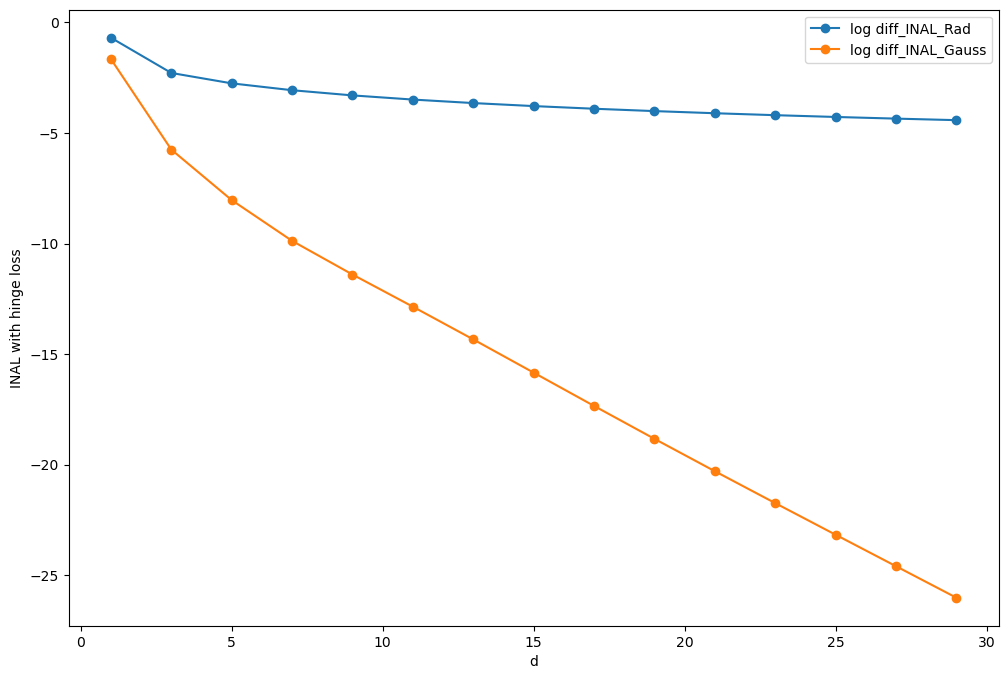

In [18]:
D = np.arange(1, 30,2)
plt.figure(figsize=(12,8))
plt.plot(D, np.log(diff_INAL_Rad_odd),"o-",label='log diff_INAL_Rad')
plt.plot(D, np.log(diff_INAL_Gauss_odd),"o-",label='log diff_INAL_Gauss')
# plt.plot(D, -0.5*np.log(D**2)-1, label='log 1/D^2')
plt.xlabel("d")
plt.ylabel("INAL with hinge loss")
plt.legend()

In [19]:
def F_full(X):
    return np.prod(X,axis =1)

def NN(X,W,b):
    return threshold(np.dot(X,W))


def generate_matrix(d):
    cartesian_product= list(product([1, -1], repeat=d))
    
    # this convert the list of all elements of {+1,-1}^d to an array of shape (2^d,d)
    matrix = np.array(cartesian_product)
    
    return matrix


d =3
matrix = generate_matrix(d)
print(matrix.shape)

(8, 3)


In [20]:
def Gamma_random(W,d,gamma):
    L=[]
    X_bin = generate_matrix(d)
    x1 = X_bin[:,0]
    b=0
    for i in range(d):
        inner = gamma*np.mean(-0.5*x1*NN(X_bin,W,b)*threshold(1-ReLU(np.dot(X_bin,W)+b))
                       -0.5*x1*NN(X_bin,W,b)*threshold(1+ReLU(np.dot(X_bin,W)+b)))
        L.append(inner)
    return L


def Junk_folw(W0,t,d,gamma):
    if t==0:
        return W0
    W=[]
    W.append(W0)
    for i in range(1,t+1):
        W.append(W[i-1]-Gamma_random(W0,d,gamma))
    return W[t]

In [21]:
N_W = 100
def run_INAL_dif_gauss_t(d,sigma,t,gamma):
    L=[]
    sumW = 0
    for tw in range(N_W):
        W0= np.random.normal(0,sigma,d)
        b=np.random.normal(0,sigma)
        W=Junk_folw(W0,t,d,gamma)
        X_bin = generate_matrix(d)
        x1 = X_bin[:,0]

        inner = np.mean(-x1*NN(X_bin,W,b)*F_full(X_bin)*threshold(1-F_full(X_bin)*ReLU(np.dot(X_bin,W)+b))+
                        0.5*x1*NN(X_bin,W,b)*threshold(1-ReLU(np.dot(X_bin,W)+b))
                       -0.5*x1*NN(X_bin,W,b)*threshold(1+ReLU(np.dot(X_bin,W)+b)))
        sumW = sumW + inner**2
    L.append(sumW/N_W)
    return np.mean(L)

# run_INAL_dif_gauss_t(5,1,0,0)

In [22]:
%%time
sigma=1
plt.figure(figsize=(12,8))
T=[2,5]
Gauss_odd=[]
for t in T:
    print(t)
    D=np.arange(1,15,2)
    INAL_dif=[]
    for d in D:
    #         if d%3==0:
    #             print(d)
        INAL_dif.append(run_INAL_dif_gauss_t(d,sigma,t,0.01))
    #     plt.subplot(3,2,T.index(t) +1)
    Gauss_odd.append(INAL_dif)
#     plt.plot(D, np.log(INAL_dif),"o-", label='normal step t='+str(t))
#     plt.xlabel("d")
#     plt.ylabel("INAL with hinge loss")
#     plt.legend();

2
5
CPU times: user 39min 10s, sys: 43.4 s, total: 39min 53s
Wall time: 1min 29s


<Figure size 1200x800 with 0 Axes>

In [23]:
%%time
sigma=1
plt.figure(figsize=(12,8))
T=[2,5]
Gauss_even=[]
for t in T:
    print(t)
    D=np.arange(2,15,2)
    INAL_dif=[]
    for d in D:
    #         if d%3==0:
    #             print(d)
        INAL_dif.append(run_INAL_dif_gauss_t(d,sigma,t,0.01))
    #     plt.subplot(3,2,T.index(t) +1)
    Gauss_even.append(INAL_dif)
#     plt.plot(D, np.log(INAL_dif),"o-", label='normal step t='+str(t))
#     plt.xlabel("d")
#     plt.legend();

2
5
CPU times: user 1h 57min 10s, sys: 2min 14s, total: 1h 59min 25s
Wall time: 3min 2s


<Figure size 1200x800 with 0 Axes>

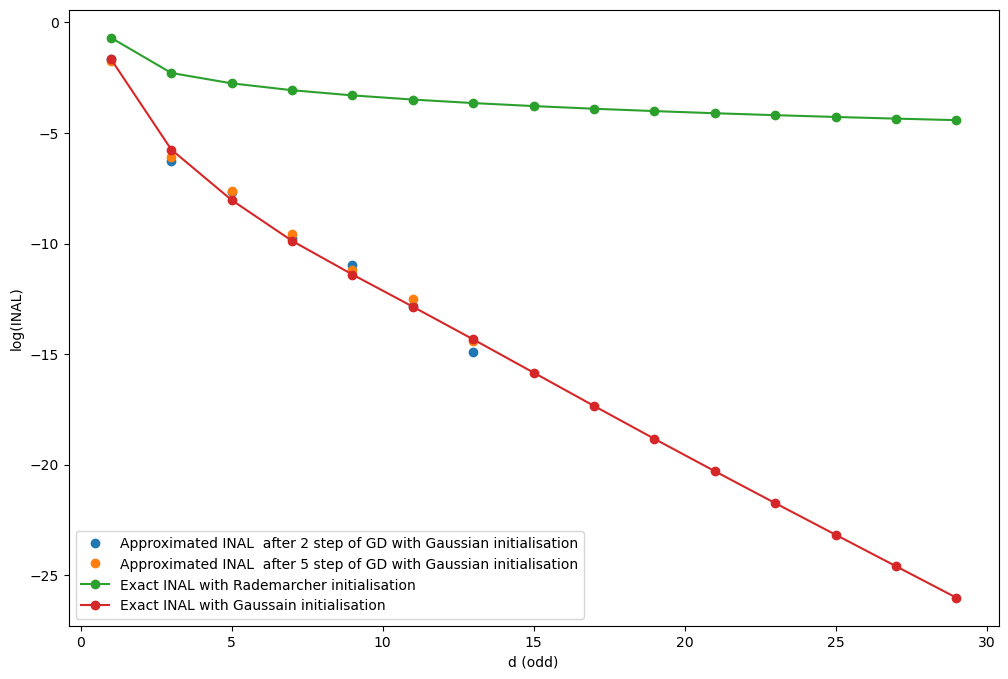

In [24]:
D1= np.arange(1,15,2)
D = np.arange(1,30,2)
plt.figure(figsize=(12,8))
plt.plot(D1, np.log(Gauss_odd[0]),"o",label='Approximated INAL  after 2 step of GD with Gaussian initialisation')
plt.plot(D1, np.log(Gauss_odd[1]),"o",label='Approximated INAL  after 5 step of GD with Gaussian initialisation')
plt.plot(D, np.log(diff_INAL_Rad_odd),"o-",label='Exact INAL with Rademarcher initialisation')
plt.plot(D, np.log(diff_INAL_Gauss_odd),"o-",label='Exact INAL with Gaussain initialisation')
# plt.plot(D, -np.log(2)*D, label='log 2^{-D}')
# plt.plot(D, -np.log(D)-1, label='log 1/D^2')
plt.xlabel("d (odd)")
plt.ylabel("log(INAL)")
plt.legend();
plt.savefig("log_INAL_hingeloss_odd.pdf", format="pdf", bbox_inches="tight")

In [65]:
saved_data = {'gauss_even_t2': Gauss_even[0], 'gauss_even_t5':Gauss_even[1], 'diff_INAL_Rad_even':diff_INAL_Rad_even,'diff_INAL_Gauss_even':diff_INAL_Gauss_even}

filepath = f"INAL_hinge_even.npz"

with open(filepath,"wb") as f:
    np.savez(f, **saved_data)           

In [3]:
### Load saved data

##Fct. to read saved data
def load_data(filepath):
#     Load the data from the .npz file
    with np.load(filepath, allow_pickle=True) as data:
#         Extracting all arrays
        gauss_even_t2 = data['gauss_even_t2']
        gauss_even_t5 = data['gauss_even_t5']
        diff_INAL_Rad_even = data['diff_INAL_Rad_even']
        diff_INAL_Gauss_even= data['diff_INAL_Gauss_even']

    # Return all loaded data
    return gauss_even_t2, gauss_even_t5, diff_INAL_Rad_even, diff_INAL_Gauss_even


filepath = f"INAL_hinge_even.npz"
gauss_even_t2, gauss_even_t5, diff_INAL_Rad_even, diff_INAL_Gauss_even = load_data(filepath)

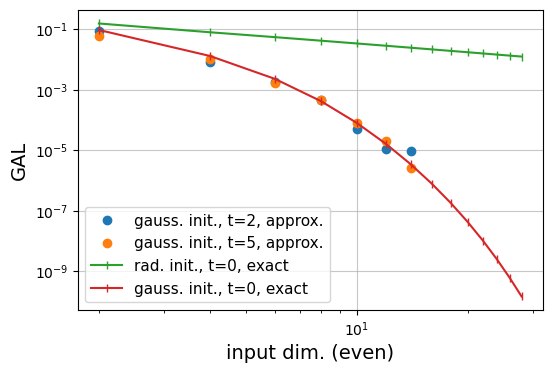

In [9]:
D1= np.arange(2,15,2)
D = np.arange(2,30,2)
fig = plt.figure(figsize = (6,3.9))
# plt.plot(D1, np.log(Gauss_even[0]),"o",label='Approximated INAL  after 2 step of GD with Gaussian initialisation')
# plt.plot(D1, np.log(Gauss_even[1]),"o",label='Approximated INAL  after 5 step of GD with Gaussian initialisation')
# plt.plot(D, np.log(diff_INAL_Rad_even),"o-",label='Exact INAL with Rademarcher initialisation')
# plt.plot(D, np.log(diff_INAL_Gauss_even),"o-",label='Exact INAL with Gaussain initialisation')
# plt.plot(D1, gauss_even_t2,"o",label=r'${\rm GAL}_f (\theta^{(2)})$,gauss. init.')
# plt.plot(D1, gauss_even_t5,"o",label=r'${\rm GAL}_f (\theta^{(5)})$,gauss. init.')
# plt.plot(D, diff_INAL_Rad_even,"|-",label=r'${\rm GAL}_f (\theta^{(0)})$ (exact),rad. init.')
# plt.plot(D, diff_INAL_Gauss_even,"|-",label=r'${\rm GAL}_f (\theta^{(0)})$ (exact),gauss. init.')

plt.plot(D1, gauss_even_t2,"o",label=r'gauss. init., t=2, approx.')
plt.plot(D1, gauss_even_t5,"o",label=r'gauss. init., t=5, approx.')
plt.plot(D, diff_INAL_Rad_even,"|-",label=r'rad. init., t=0, exact')
plt.plot(D, diff_INAL_Gauss_even,"|-",label=r'gauss. init., t=0, exact')


# # plt.plot(D, -np.log(2)*D, label='log 2^{-D}')
# plt.plot(D, -np.log(D)-1, label='log 1/D^2')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("input dim. (even)",fontsize=14)
plt.ylabel("GAL",fontsize=14)
plt.grid(True,alpha=0.7)
plt.legend(fontsize = 11,loc='best');
# plt.savefig("log_INAL_hingeloss_even.pdf", format="pdf", bbox_inches="tight")

In [10]:
fig.savefig("log_INAL_hingeloss_even.pdf", bbox_inches="tight")

In [69]:
# D1= np.arange(2,15,2)
# D = np.arange(2,30,2)
# fig = plt.figure(figsize = (6,3.9))
# # plt.plot(D1, np.log(Gauss_even[0]),"o",label='Approximated INAL  after 2 step of GD with Gaussian initialisation')
# # plt.plot(D1, np.log(Gauss_even[1]),"o",label='Approximated INAL  after 5 step of GD with Gaussian initialisation')
# # plt.plot(D, np.log(diff_INAL_Rad_even),"o-",label='Exact INAL with Rademarcher initialisation')
# # plt.plot(D, np.log(diff_INAL_Gauss_even),"o-",label='Exact INAL with Gaussain initialisation')
# plt.plot(D1, np.log(Gauss_even[0]),"o",label=r'${\rm GAL}_f (\theta^{(2)})$,gauss. init.')
# plt.plot(D1, np.log(Gauss_even[1]),"o",label=r'${\rm GAL}_f (\theta^{(5)})$,gauss. init.')
# plt.plot(D, np.log(diff_INAL_Rad_even),"|-",label=r'${\rm GAL}_f (\theta^{(0)})$ (exact),rad. init.')
# plt.plot(D, np.log(diff_INAL_Gauss_even),"|-",label=r'${\rm GAL}_f (\theta^{(0)})$ (exact),gauss. init.')

# # # plt.plot(D, -np.log(2)*D, label='log 2^{-D}')
# # plt.plot(D, -np.log(D)-1, label='log 1/D^2')
# plt.xlabel("input dim. (even)",fontsize=14)
# plt.ylabel("log(GAL)",fontsize=14)
# plt.grid(True,alpha=0.7)
# plt.legend(fontsize = 10,loc='best');
# # plt.savefig("log_INAL_hingeloss_even.pdf", format="pdf", bbox_inches="tight")

In [60]:
# fig.savefig("log_INAL_hingeloss_even.pdf", format="pdf", bbox_inches="tight")